Rita Kurban 

Professor Scheffler

CS166

## Part 1: Traffic jams on a circular road

In [20]:
# Install all the necessary packages
import math
import random
from random import randint
import pylab
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [21]:
class TrafficSimulation:
    """A class that simulates traffic on a single lane. """
  
    def __init__(self, length, density, maxvel, prob):
        """Initializes the instance of a simulation. The user has to specify the length of the road,
        the initial density, maximum velocity and the probability of slowing down.
        """
        self.length = length
        self.density = density
        self.maxvel = maxvel
        self.prob = prob
        self.config = pylab.zeros(self.length)
        for i in range(self.length):
            if pylab.random() > self.density:
                self.config[i] = -1
            else:
                self.config[i] = randint(0, self.maxvel)
    
    def update(self):
        """Updates velocities based on the Nagel & Schreckenberg traffic model rules:
        Accelerates +1 if distance to the next car is bigger than the speed.
        Slows down to distance - 1 if distance to the next car is smaller than the speed.
        Randomly decreases the velocity by 1 if the car moves.
        Moves each car forward.
        Returns the flow which is the number of cars that pass the last cell of the simulation
        and reappear at the beginning.
        """ 
        flow = 0
        move = [-1 for i in range(self.length)]
        for count, value in enumerate(self.config):
            if value >= 0:
                dist = 1
                # Periodic boundary conditions
                while self.config[(count + dist) % self.length] == -1:
                    dist += 1
                if dist > value + 1:
                    self.config[count] = min(self.config[count] + 1, self.maxvel)
                else:
                    self.config[count] = dist - 1
                if self.config[count] > 0 and random.random() < self.prob:
                    self.config[count] -= 1
                
                var = int(count + self.config[count])
                move[var % self.length] = self.config[count]
            if (count + value) > self.length:
                flow += 1    
        self.config = move
        return flow
    


    def simulation(self, n, show = False):
        """Runs the simulation n times.
        If show is set to "True" prints out the lane.
        Returns the average flow.
        """
        flows = []
        summ = 0
        for i in range(n):
            if show:
                print self.display()
            flows.append(self.update())
            summ += flows[-1]
        return summ / float(len(flows))
  
    def display(self):
        """Visualizes the states. """
        return ''.join('.' if x == -1 else str(int(x)) for x in self.config)
        
for i in [0.01, 0.05, 0.1,0.3]:
    traffic = TrafficSimulation(70, i, 5, 0.5)
    print "Density", i
    print traffic.simulation(n =10, show = True)

Density 0.01
..............5........4..................................51..........
..................4........4..............................0.1.........
.......................5........5.........................0..1........
...........................4........4.....................0....2......
...............................4.........5.................1.....2....
....................................5.........5..............2......3.
..4......................................5.........5...........2......
......4......................................4.........4.........2....
...........5.....................................4.........4.......2..
3...............5....................................4..........5.....
0.1
Density 0.05
..3...4.................0.........3.................................03
.2..2......5.............1............4.............................0.
..1...2.........5..........2..............4.........................0.
....2...2............5.......2.................

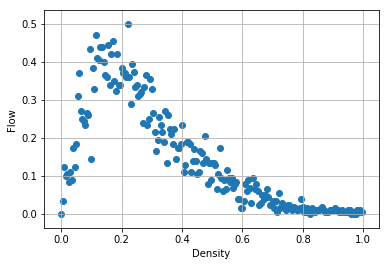

In [22]:
# Graphing the flow and densities
densities = np.arange(0.0, 1, 0.005)
flow = [TrafficSimulation(100, d, 5, .2).simulation(n=200) for d in densities]


plt.scatter(densities, flow)
plt.ylabel("Flow")
plt.xlabel("Density")
plt.grid(True)
plt.show()

## Part 2: Multi-lane highways

In [23]:
class Traffic:
    """An extended class that simulates traffic on different number of lanes. """
  
    def __init__(self, length, density, maxvel, prob, n_lanes, switch):
        """ Initializes the instance of a simulation. The user has to specify
        the length of the road, the initial density, max velocity, the probability
        of slowing down, the number of lanes, and the probability to switch the lanes.
        """
        self.length = length
        self.density = density
        self.maxvel = maxvel
        self.prob = prob
        self.config = sc.zeros([n_lanes, length], int)
        self.n_lanes = n_lanes
        self.switch = switch
        for j in range(n_lanes):
            for i in range(self.length):
                if pylab.random() > self.density:
                    self.config[j,i] = -1
                else:
                    self.config[j,i] = randint(0, self.maxvel)
    
    def update(self):
        """This method first switches the lane if necessary and then updates velocities
        based on the Nagel & Schreckenberg traffic model rules.
        To switch the lane:
        Look forward and check if the gap is bigger than L(how far to look ahead on your lane).
        In case this gap is smaller, check the second lane. 
        If there are enough empty cells there (>L0), look backward. 
        If the gap is bigger than L0b, switch the lane with a probability "switch". 
        After that:
        Accelerate +1 if distance to the next car is bigger than the speed.
        Slow down to distance - 1 if distance to the next car is smaller than the speed.
        Randomly decrease the velocity by 1 if the car moves.
        Move each car forward.
        """ 
        for lane in range(len(self.config)):
            for count, value in enumerate(self.config[lane]):
                if value >= 0:
                    L = 1
                    # Periodic boundary conditions
                    while self.config[lane, (count + L) % self.length] == -1:
                        L += 1
                    if L >= value + 1:
                        continue
                    L0 = 0
                    L0b = 0
                    # First check if there is space on the right
                    if lane + 1 < self.n_lanes:
                        while self.config[lane + 1, (count + L0) % self.length] == -1:
                            L0 += 1
                        if L0 <= value + 1:
                            continue
                        while self.config[lane + 1, (count - L0b) % self.length] == -1:
                            L0b += 1
                        if L0b < self.maxvel:
                            continue
                        if random.random() < self.switch:
                            self.config[lane, count] = -1
                            self.config[lane + 1, count] = value
                            continue
                    # If there is no space to the right, check the lane to the left
                    if lane - 1 >= 0:
                        while self.config[lane - 1, (count + L0) % self.length] == -1:
                            L0 += 1
                        if L0 <= value + 1:
                            continue
                        while self.config[lane - 1, (count - L0b) % self.length] == -1:
                            L0b += 1
                        if L0b < self.maxvel:
                            continue
                        if random.random() < self.switch:
                            self.config[lane, count] = -1
                            self.config[lane - 1, count] = value
                            continue
     
        flow = 0
        position = 0
        move = sc.ones([self.n_lanes, self.length], int) * -1
        for lane in range(len(self.config)):
            for count, value in enumerate(self.config[lane]):
                if value >= 0:
                    dist = 1
                    # Periodic boundary conditions
                    while self.config[lane, (count + dist) % self.length] == -1:
                        dist += 1
                    if dist > value + 1:
                        self.config[lane, count] = min(self.config[lane, count] + 1, self.maxvel)
                    else:
                        self.config[lane, count] = dist - 1
                    if self.config[lane, count] > 0 and random.random() < self.prob:
                        self.config[lane, count] -= 1
                    position = int(count + self.config[lane, count])
                    move[lane, position % self.length] = self.config[lane, count]
                if (count + value) > self.length:
                    flow += 1 
        self.config = move
        return flow / (self.n_lanes * 1.0)
    
    def simulation(self, n, show = False):
        flows = []
        summ = 0
        for i in range(n):
            if show:
                print self.display()
            flows.append(self.update())
            summ += flows[-1]
        return summ / float(len(flows))
  
    def display(self):
        """Visualizes the states. """
        return '\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in self.config) + "\n"

for i in [0.01, 0.05, 0.1,0.3]:
    traffic = Traffic(70, i, 5, 0.5, 5, 1)
    print "Density", i
    print traffic.simulation(n =10, show = True)


Density 0.01
....4...................4.............................................
......................................................................
..............1.......................................................
.......................4..............................................
..........................................................2...........

........4...................4.........................................
......................................................................
................2.....................................................
............................5.........................................
.............................................................3........

............4....................5....................................
......................................................................
..................2...................................................
.................................5............................

In [ ]:
# Graphing the flow and densities for the multilane model
densities = np.arange(0.0, 1, 0.01)
f = [Traffic(100, d, 5, .2, 2, 1).simulation(n=200) for d in densities]


plt.scatter(densities, f)
plt.ylabel("Flow")
plt.xlabel("Density")
plt.grid(True)
plt.show()

## Part 3: Stretch Goals

In [19]:
class Traffic:
    """An extended class that simulates traffic on different number of lanes. """
  
    def __init__(self, length, density, maxvel, prob, n_lanes, switch, bad_road = .2, traffic_lights = 0.1):
        """ Initializes the instance of a simulation. The user has to specify
        the length of the road, the initial density, max velocity, the probability
        of slowing down, the number of lanes, the probability to switch the lanes, 
        the length of bad road, and the probability of having traffic lights.
        """
        self.count = 0
        self.length = length
        self.density = density
        self.maxvel = maxvel
        self.prob = prob
        self.config = sc.zeros([n_lanes, length], int)
        self.n_lanes = n_lanes
        self.switch = switch
        self.traffic_lights = traffic_lights
        # Initiate maxvel to be the speed limit for every cell
        self.speed_limits_red = sc.ones([n_lanes, length], int) * self.maxvel 
        self.speed_limits_green = sc.ones([n_lanes, length], int) * self.maxvel 
        # Implement bad road
        self.start = randint(0, self.length)
        self.finish = (self.start + int(bad_road * length)) % length
        self.Green = False
        if self.start < self.finish:
            for j in range(n_lanes):
                for i in range(self.start, self.finish):
                    self.speed_limits_red[j,i] = int(self.maxvel * 0.5)
                    self.speed_limits_green[j,i] = int(self.maxvel * 0.5)
        else:
            for j in range(n_lanes):
                for i in range(self.finish, self.start):
                    self.speed_limits_red[j,i] = int(self.maxvel * 0.5)
                    self.speed_limits_green[j,i] = int(self.maxvel * 0.5)
        # Traffic lights
        for x in range(self.length):
            if random.random() < self.traffic_lights:
                self.speed_limits_red[:,x] = 0
        for j in range(n_lanes):
            for i in range(self.length):
                if pylab.random() > self.density:
                    self.config[j,i] = -1
                else:
                    self.config[j,i] = randint(0, self.maxvel)
     
    def update(self):
        """This method first switches the lane if necessary and then updates velocities
        based on the Nagel & Schreckenberg traffic model rules.
        To switch the lane:
        Look forward and check if the gap is bigger than L(how far to look ahead on your lane).
        In case this gap is smaller, check the second lane. 
        If there are enough empty cells there (>L0), look backward. 
        If the gap is bigger than L0b, switch the lane with a probability "switch". 
        After that:
        Accelerate +1 if distance to the next car is bigger than the speed.
        Slow down to distance - 1 if distance to the next car is smaller than the speed.
        Randomly decrease the velocity by 1 if the car moves.
        Move each car forward.
        It also accounts for traffic lights by switching the light every 10 steps.
        """            
        for lane in range(len(self.config)):
            for count, value in enumerate(self.config[lane]):
                if value >= 0:
                    L = 1
                    # Periodic boundary conditions
                    while self.config[lane, (count + L) % self.length] == -1: 
                        L += 1
                    if L >= value + 1:
                        continue
                    L0 = 0
                    L0b = 0
                    # First check if there is space on the right
                    if lane + 1 < self.n_lanes:
                        while self.config[lane + 1, (count + L0) % self.length] == -1:
                            L0 += 1
                        if L0 <= value + 1:
                            continue
                        while self.config[lane + 1, (count - L0b) % self.length] == -1:
                            L0b += 1
                        if L0b < self.maxvel:
                            continue
                        if random.random() < self.switch:
                            self.config[lane, count] = -1
                            self.config[lane + 1, count] = value
                            continue
                    # If there is no space to the right, check the lane to the left
                    if lane - 1 >= 0:
                        while self.config[lane - 1, (count + L0) % self.length] == -1:
                            L0 += 1
                        if L0 <= value + 1:
                            continue
                        while self.config[lane - 1, (count - L0b) % self.length] == -1:
                            L0b += 1
                        if L0b < self.maxvel:
                            continue
                        if random.random() < self.switch:
                            self.config[lane, count] = -1
                            self.config[lane - 1, count] = value
                            continue
        self.count += 1 
        flow = 0
        position = 0
        move = sc.ones([self.n_lanes, self.length], int) * -1
        for lane in range(len(self.config)):
            for count, value in enumerate(self.config[lane]):
                if value >= 0:
                    dist = 1
                    # Periodic boundary conditions
                    while self.config[lane, (count + dist) % self.length] == -1:
                        # If the light is red, car cannot pass it
                        if not self.Green:
                            if self.speed_limits_red[lane,(count + dist) % self.length] == 0:
                                break
                        dist += 1
                    if dist > value + 1:
                        # Selecting the new speed based on the traffic lights
                        if not self.Green:
                            self.config[lane, count] = min(self.config[lane, count] + 1, self.speed_limits_red[lane,count])
                        else:
                            self.config[lane, count] = min(self.config[lane, count] + 1, self.speed_limits_green[lane,count])
                    else:
                        self.config[lane, count] = dist - 1
                    if self.config[lane, count] > 0 and random.random() < self.prob:
                        self.config[lane, count] -= 1
                    position = int(count + self.config[lane, count])
                    move[lane, position % self.length] = self.config[lane, count]
                if (count + value) > self.length:
                    flow += 1 
        self.config = move
        # Periodically change the color 
        if self.count % 5 == 0:
            self.Green = not self.Green
        return flow / (self.n_lanes * 1.0)
    
    def simulation(self, n, show = False):
        flows = []
        summ = 0
        self.green = False
        for i in range(n):
            if show:
                print self.display()
            flows.append(self.update())
            summ += flows[-1]
        return summ / float(len(flows))
  
    def display(self):
        """Visualizes the states. """
        return '\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in self.config) + "\n"

traffic = Traffic(70, 0.2, 5, 0.1, 2, 1)
print traffic.speed_limits_green
print traffic.simulation(n =100, show = True)

[[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]]
.4.4..........0333............505.5....1.....0......4.......3..05..5..
1525.5.0.45...0.1..........4.......3....1......5....11.0.........3..3.

30....3.......000....4........000.0......2....1.......2........0..2...
000.1.10.0.1...1..2..........2.....0....0..........40.10....0......2.1

0.1...0.......00.1......3.....000.0......0.....1......0.........1....3
000..100..10.....2...3.......0.....0.....1.........0.100....0.......10

.1..2.0.......0.1..2....0.....000.0......0.......2....0...........2..0
00.1.000..00........3..2.....0.....0.....0..........1000....0.......00

1.1..10........1.1...2..0.....000.0......0..........3.0.............2.
0.1.1000..00..........2.1....0.....0.....0..........0000....0.....